# Counterfactuals

## Introduction

To create the dataset, we will use the same technique as used in {ref}`data:classification`.

We will create two well separated clusters in $\mathbb{R}^2$, corresponding to two features $f_1$ and $f_2$, with an associated outcome $y=f(f_1, f_2)$ with possible values _true_ ($y=1$) and _false_ ($y=1$).

In [1]:
import pandas as pd
from sklearn.datasets import make_classification

RANDOM_STATE = 23
N_FEATURES = 2
N = 100

data = make_classification(
    n_samples=N,
    n_features=N_FEATURES,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    weights=None,
    flip_y=0.01,
    class_sep=2.0,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=RANDOM_STATE,
)
df = pd.DataFrame(data[0], columns=["f1", "f2"])

df["y"] = data[1]

x1 = df[df["y"] == 0]["f1"]
y1 = df[df["y"] == 0]["f2"]
x2 = df[df["y"] == 1]["f1"]
y2 = df[df["y"] == 1]["f2"]

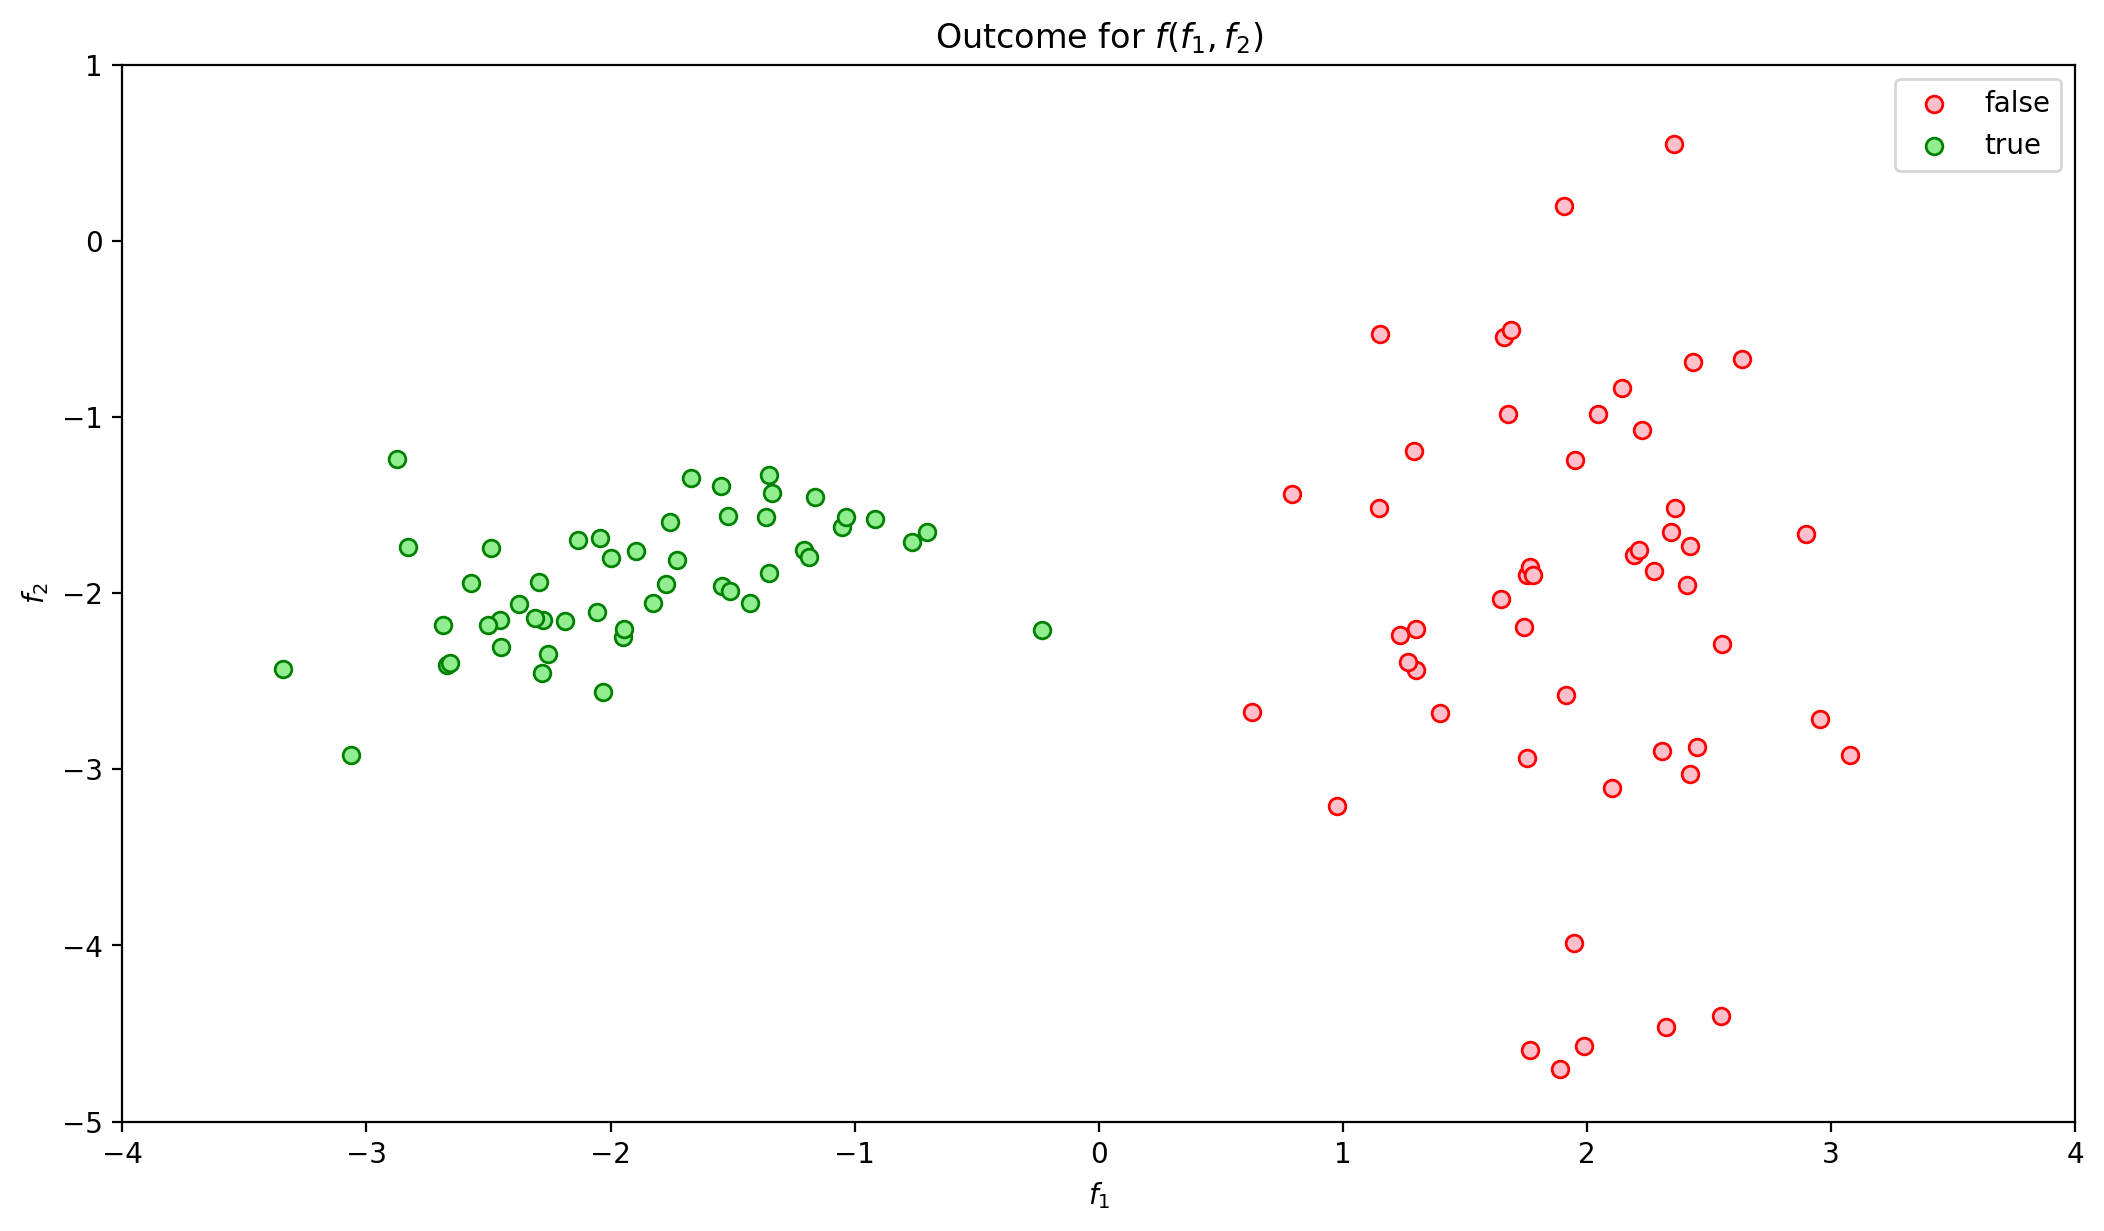

In [2]:
import matplotlib.pyplot as plt

from plotutils import *

x_min = -4
x_max = 4
y_min = -5
y_max = 1


plt.scatter(x1, y1, c=colours[0], edgecolor=edges[0], label="false")
plt.scatter(x2, y2, c=colours[1], edgecolor=edges[1], label="true")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel("$f_1$")
plt.ylabel("$f_2$")
plt.title("Outcome for $f(f_1, f_2)$")
plt.legend(loc="upper right")
plt.show()

We will now train an SVC model with the generated data.

In [3]:
from sklearn.svm import SVC

X = df[["f1", "f2"]].to_numpy()
Y = df["y"]

svm = SVC(gamma="scale", probability=True)
svm.fit(X, Y)

SVC(probability=True)

And calculate the model's accuracy.

In [4]:
print("SVM classification accuracy: ", svm.score(X, Y))

SVM classification accuracy:  1.0


We are now interested in predicting the counterfactual of a certain point $p=(f_1, f_2)$.

To do it, we first chose a point and determined its predicted outcome, $y=f(p)$. We then proceed to find the closest set of features that would produce the opposite outcome, that is

$$
p^{\prime}=(f_1^{\prime}, f_2^{\prime}): y^{\prime}=f(p^{\prime})=\sim y
$$

Let's define our input as point $p=(-0.5, -1)$ and visualise it along with the predicted outcome.

In [5]:
import numpy as np

p = [-0.5, -1]

p_input = np.array(p).reshape(1, -1)
p_prediction = svm.predict(p_input)
print(f"y=f({p}) predicted as " + "true" if p_prediction[0] == 1 else "false")

y=f([-0.5, -1]) predicted as true


We therefore are interested in the set of features $p^{\prime}$ which will have a prediction of _false_.

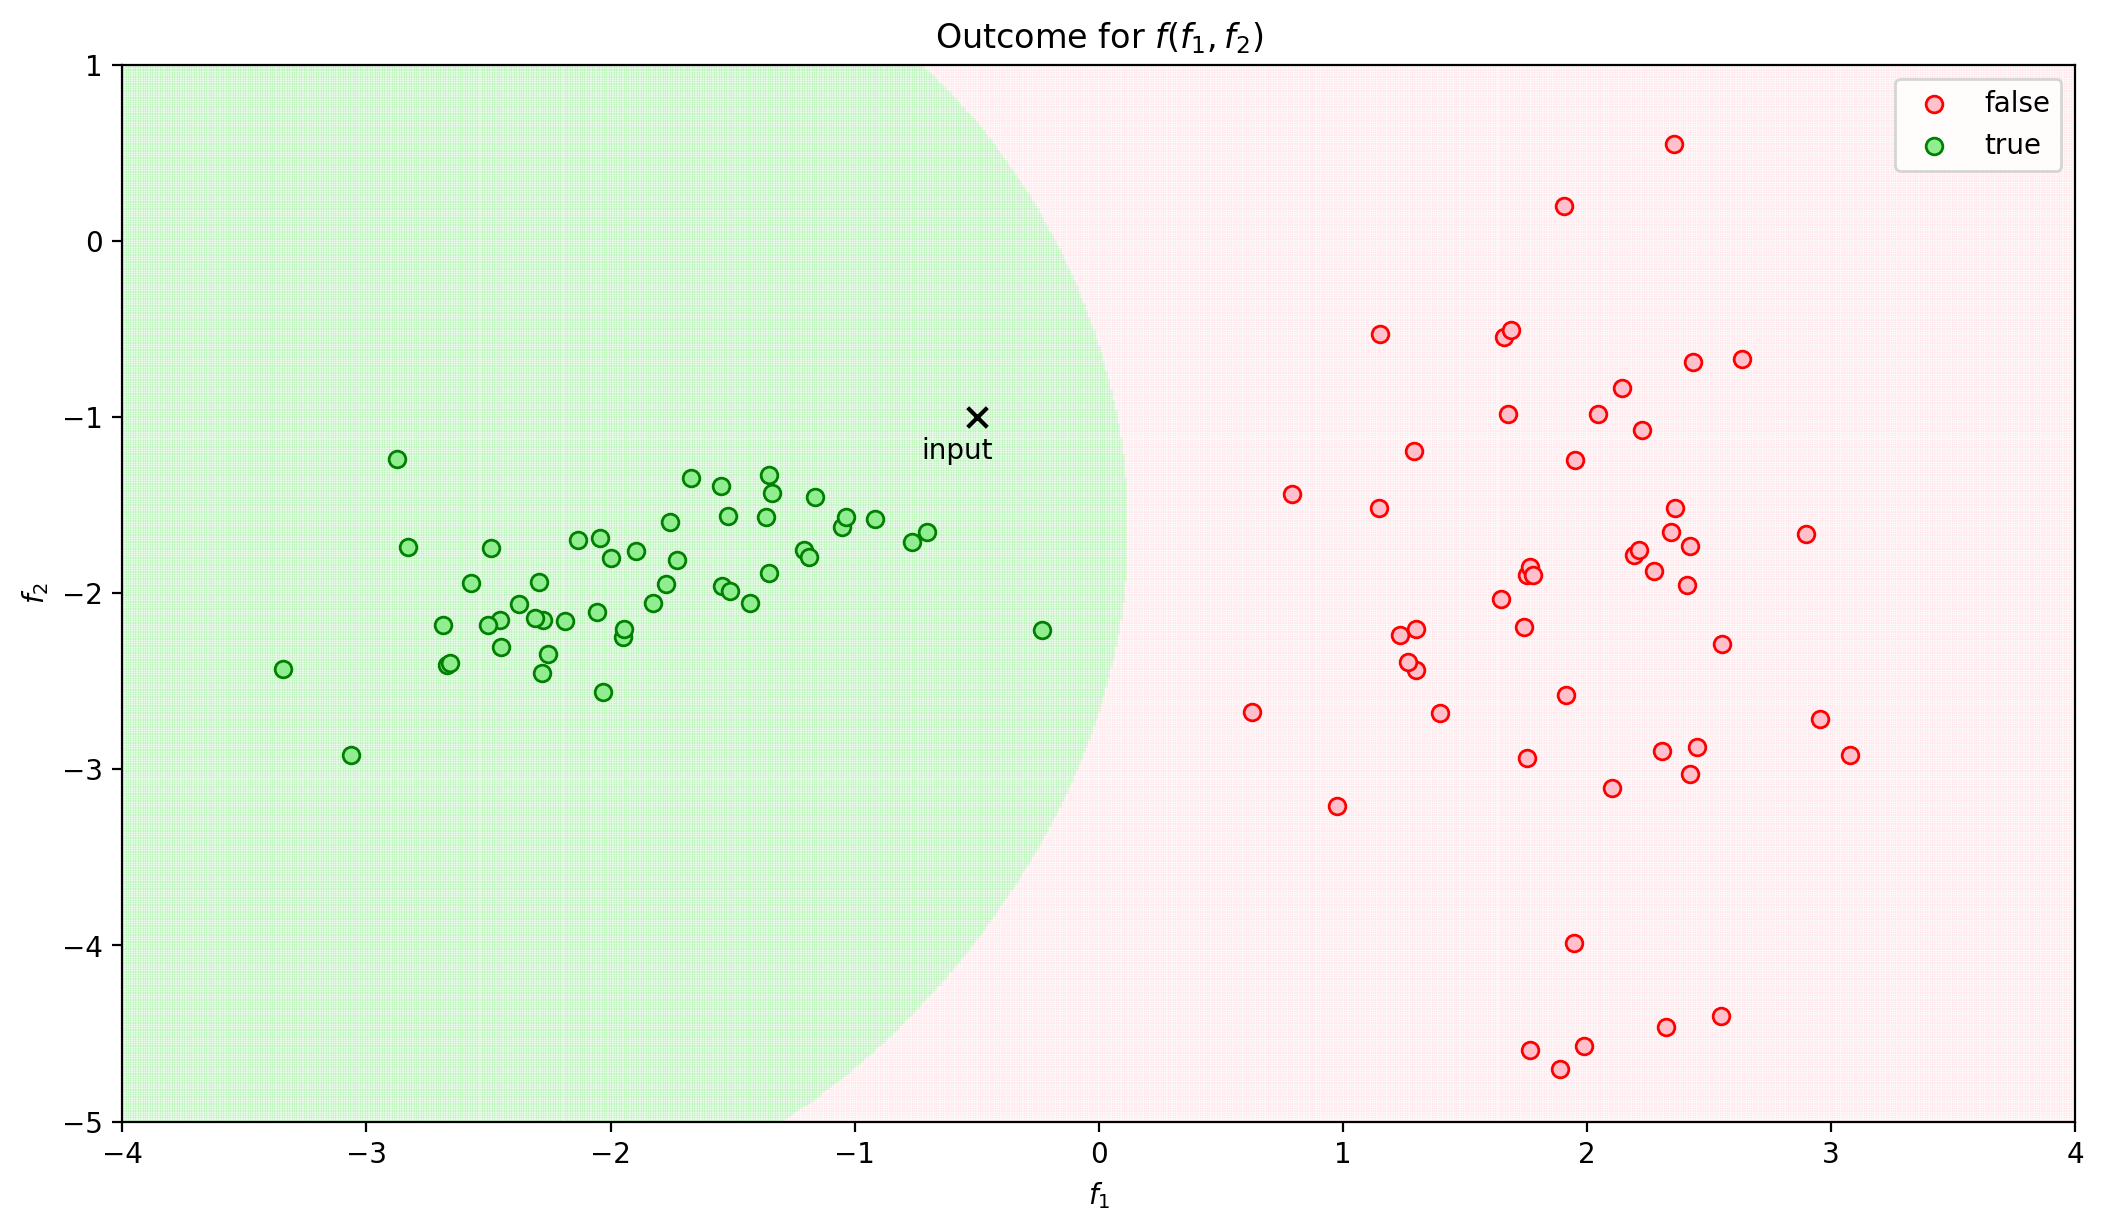

In [6]:
import numpy as np
from matplotlib.colors import ListedColormap

cmap = ListedColormap(
    [adjust_opacity(colours[0], 0.1), adjust_opacity(colours[1], 0.2)]
)

h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap, shading="auto")
plt.scatter(x1, y1, c=colours[0], edgecolor=edges[0], label="false")
plt.scatter(x2, y2, c=colours[1], edgecolor=edges[1], label="true")
plt.scatter(p[0], p[1], s=50, c="black", marker="x")
plt.annotate(
    "input",
    xy=(p[0], p[1]),
    xytext=(-20, -15),
    textcoords="offset points",
)

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel("$f_1$")
plt.ylabel("$f_2$")
plt.title("Outcome for $f(f_1, f_2)$")
plt.legend(loc="upper right")
plt.show()

We define now a function, `nearest`, which will return the existing data _point_ that is closest to the input and which provides a counterfactual (that is, `false` outcome).

In [7]:
def nearest(p, data):
    """Return the data point closest to p, which has a 'false' outcome"""
    data_n = data[data["y"] == 0]
    distances = dist.pairwise(data_n[["f1", "f2"]], p)
    data_n.insert(3, "distances", distances, True)
    index_min = data_n.distances.idxmin()
    nearest_point = np.array(
        [data_n.loc[index_min]["f1"], data_n.loc[index_min]["f2"]]
    ).reshape(1, -1)
    return nearest_point, index_min

## Nelder-Mead method

We also define the following functions to determine the distance used in the loss function.

The `cityblock` metric corresponds to the _Manhattan distance_. If we assume two points $p$ and $q$, their Manhattan distance is defined by:

$$
d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|
$$

In [8]:
def loss_function_l1norm(x_dash):
    L = 2 * (logreg.predict(x_dash.reshape(1, -1)) - 1) ** 2 + cdist(
        example, x_dash.reshape(1, -1), metric="cityblock"
    )
    return L


def dist_mad(cf, eg):
    manhat = [
        cdist(eg.T, cf.reshape(1, -1).T, metric="cityblock")[i][i]
        for i in range(len(eg.T))
    ]
    mad = stats.median_abs_deviation(X, scale="normal")
    return sum(manhat / mad)


def loss_function_mad(x_dash):
    target = 0
    L = lamda * (
        svm.predict_proba(x_dash.reshape(1, -1))[0][target] - 1
    ) ** 2 + dist_mad(x_dash.reshape(1, -1), p_input)
    return L

For completeness we will also show the data point which is _closest_ to our original input $p$, but with a different outcome.

In [9]:
from scipy.optimize import minimize
from sklearn.neighbors import DistanceMetric

# nearest neighbour
dist = DistanceMetric.get_metric("euclidean")
cf_nn, i = nearest(p_input, df)

while int(svm.predict(cf_nn)) != 0:
    data_input = df.drop([i])
    cf_nn, i = nearest(p_input, data_input)

prediction = "true" if svm.predict(cf_nn)[0] == 1 else "false"
print(f"p=({cf_nn}) predicted as {prediction}")

p=([[ 0.79255422 -1.43485286]]) predicted as false


We use the _Nelder-Mead_ method to minimise the loss function `loss_function_mad`.

In [10]:
from scipy import stats
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist

pred_threshold = 0.90

# initial conditions
lamda = 0.1
x0 = np.array([0.5, 0.0]).reshape(1, -1)  # initial guess for cf

res = minimize(
    loss_function_mad,
    x0,
    method="nelder-mead",
    options={"maxiter": 1000, "xatol": 1e-8},
)
cf = res.x.reshape(1, -1)

TARGET = 0  # false
prob_target = svm.predict_proba(cf)[0][TARGET]

i = 0
while prob_target < pred_threshold:
    lamda += 0.1
    x0 = cf  # starting point is current cf
    res = minimize(
        loss_function_mad,
        x0,
        method="nelder-mead",
        options={"maxiter": 1000, "xatol": 1e-8},
    )
    cf = res.x.reshape(1, -1)
    prob_target = svm.predict_proba(cf)[0][TARGET]
    i += 1
    if i == 3000:
        print("Error condition not met after", i, "iterations")
        break

print(
    f"Found counterfactual: {cf[0]} after {i} steps. This point has "
    + f"an outcome of {svm.predict(cf)[0]} with a probability {svm.predict_proba(cf)[0].max()}"
)

Found counterfactual: [ 0.69940487 -1.        ] after 60 steps. This point has an outcome of 0 with a probability 0.9000320445031967


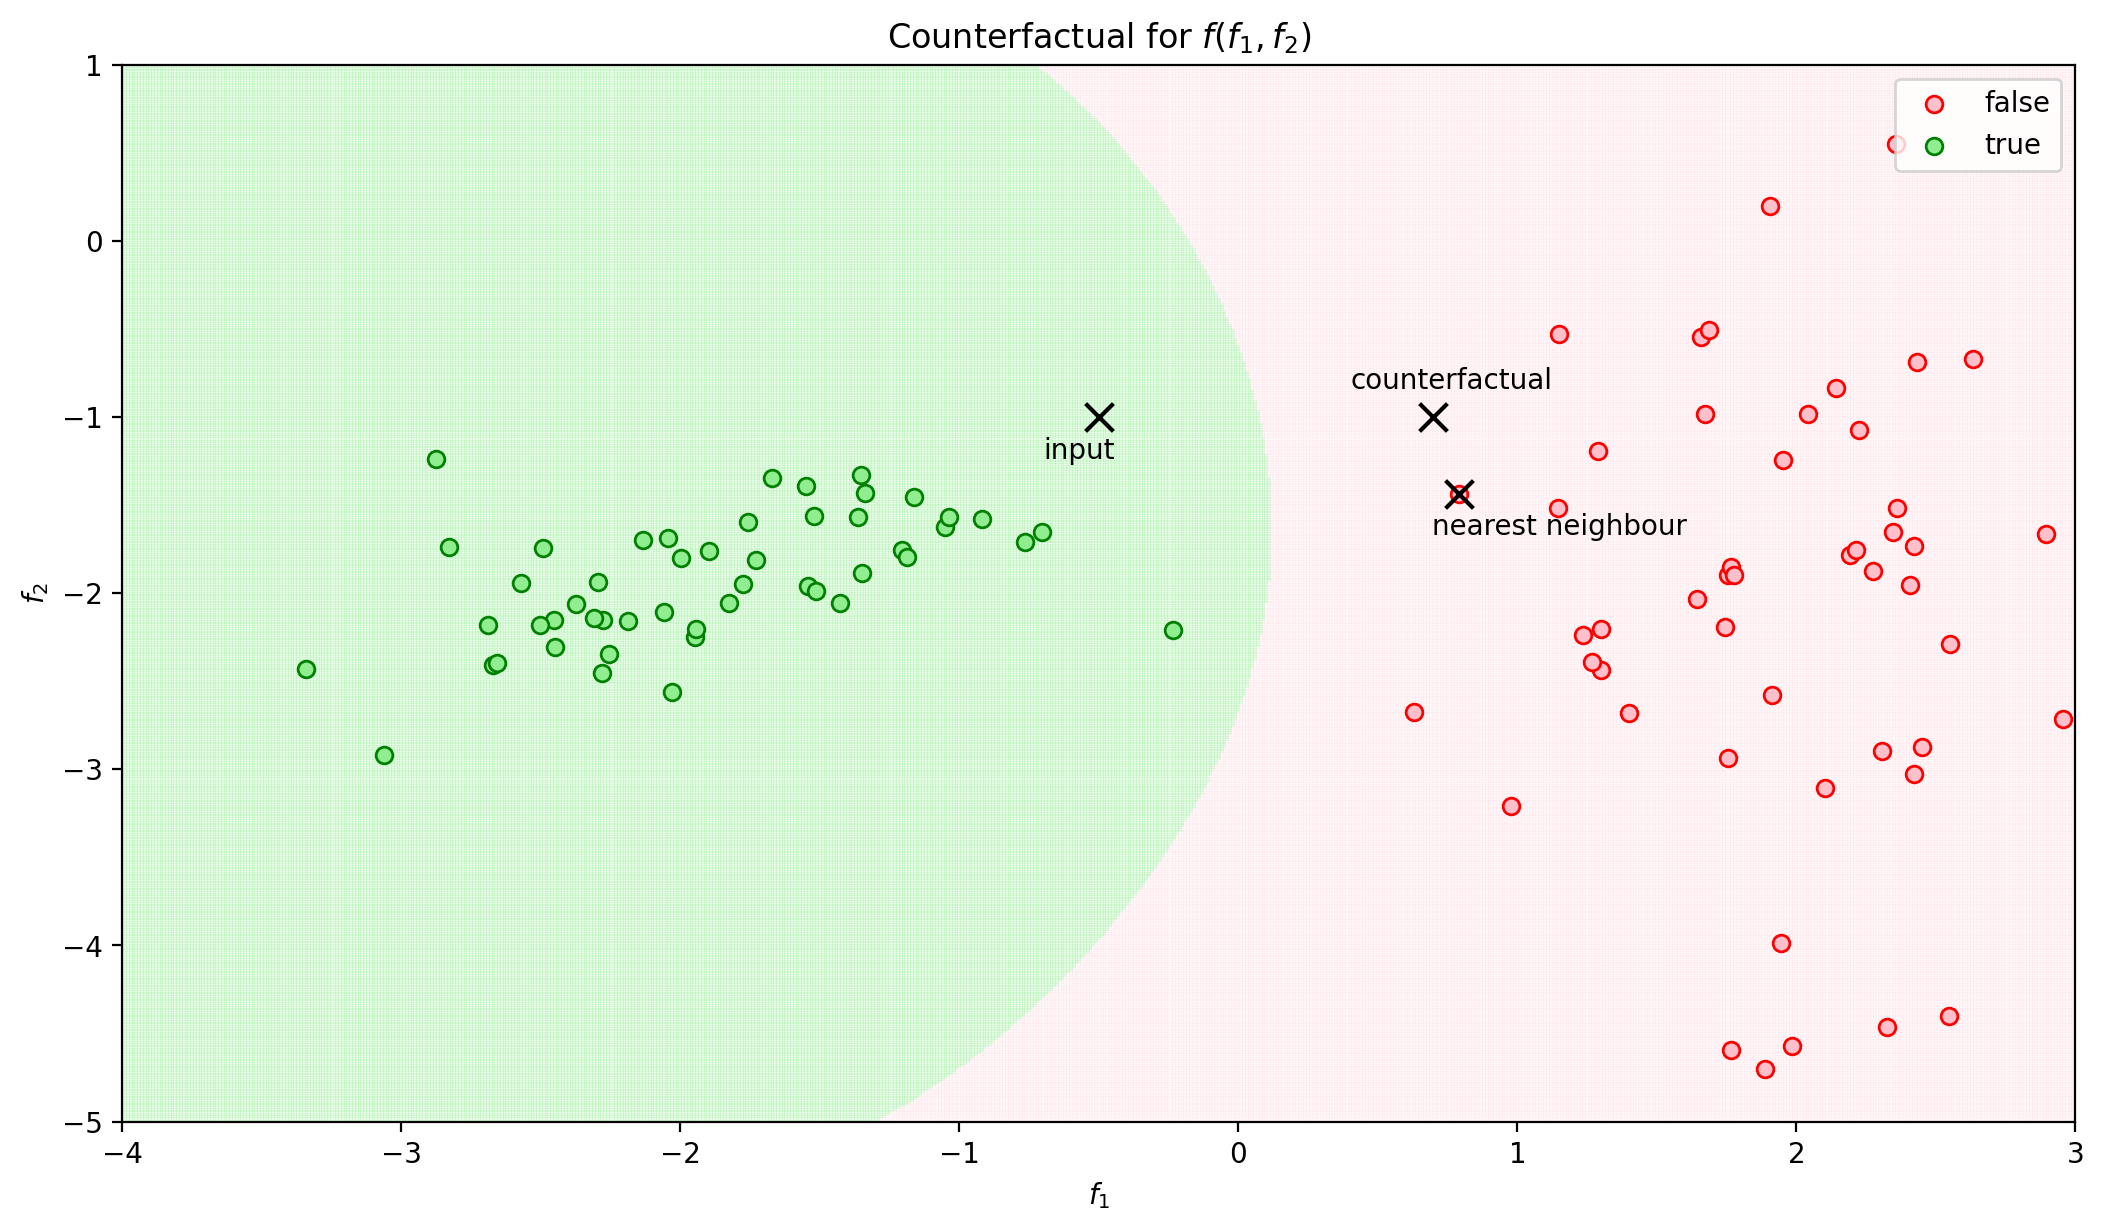

In [11]:
plt.pcolormesh(xx, yy, Z, cmap=cmap, shading="auto")
plt.scatter(x1, y1, c=colours[0], edgecolor=edges[0], label="false")
plt.scatter(x2, y2, c=colours[1], edgecolor=edges[1], label="true")

plt.scatter(p_input[0][0], p_input[0][1], s=100, c="black", marker="x")
plt.annotate(
    "input",
    xy=(p_input[0][0], p_input[0][1]),
    xytext=(-20, -15),
    textcoords="offset points",
)

plt.scatter(cf[0][0], cf[0][1], s=100, c="black", marker="x")
plt.annotate(
    "counterfactual",
    xy=(cf[0][0], cf[0][1]),
    xytext=(-30, 10),
    textcoords="offset points",
)

plt.scatter(cf_nn[0][0], cf_nn[0][1], s=100, c="black", marker="x")
plt.annotate(
    "nearest neighbour",
    xy=(cf_nn[0][0], cf_nn[0][1]),
    xytext=(-10, -15),
    textcoords="offset points",
)

plt.xlim([x_min, x_max - 1])
plt.ylim([y_min, y_max])
plt.xlabel("$f_1$")
plt.ylabel("$f_2$")
plt.title("Counterfactual for $f(f_1, f_2)$")
plt.legend(loc="upper right")
plt.show()

plt.show()

## Growing Spheres method

The _Growing Spheres_ method {cite}`laugel2017inverse` consists of:

In [14]:
from sklearn.model_selection import train_test_split

X = df[["f1", "f2"]].to_numpy()
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

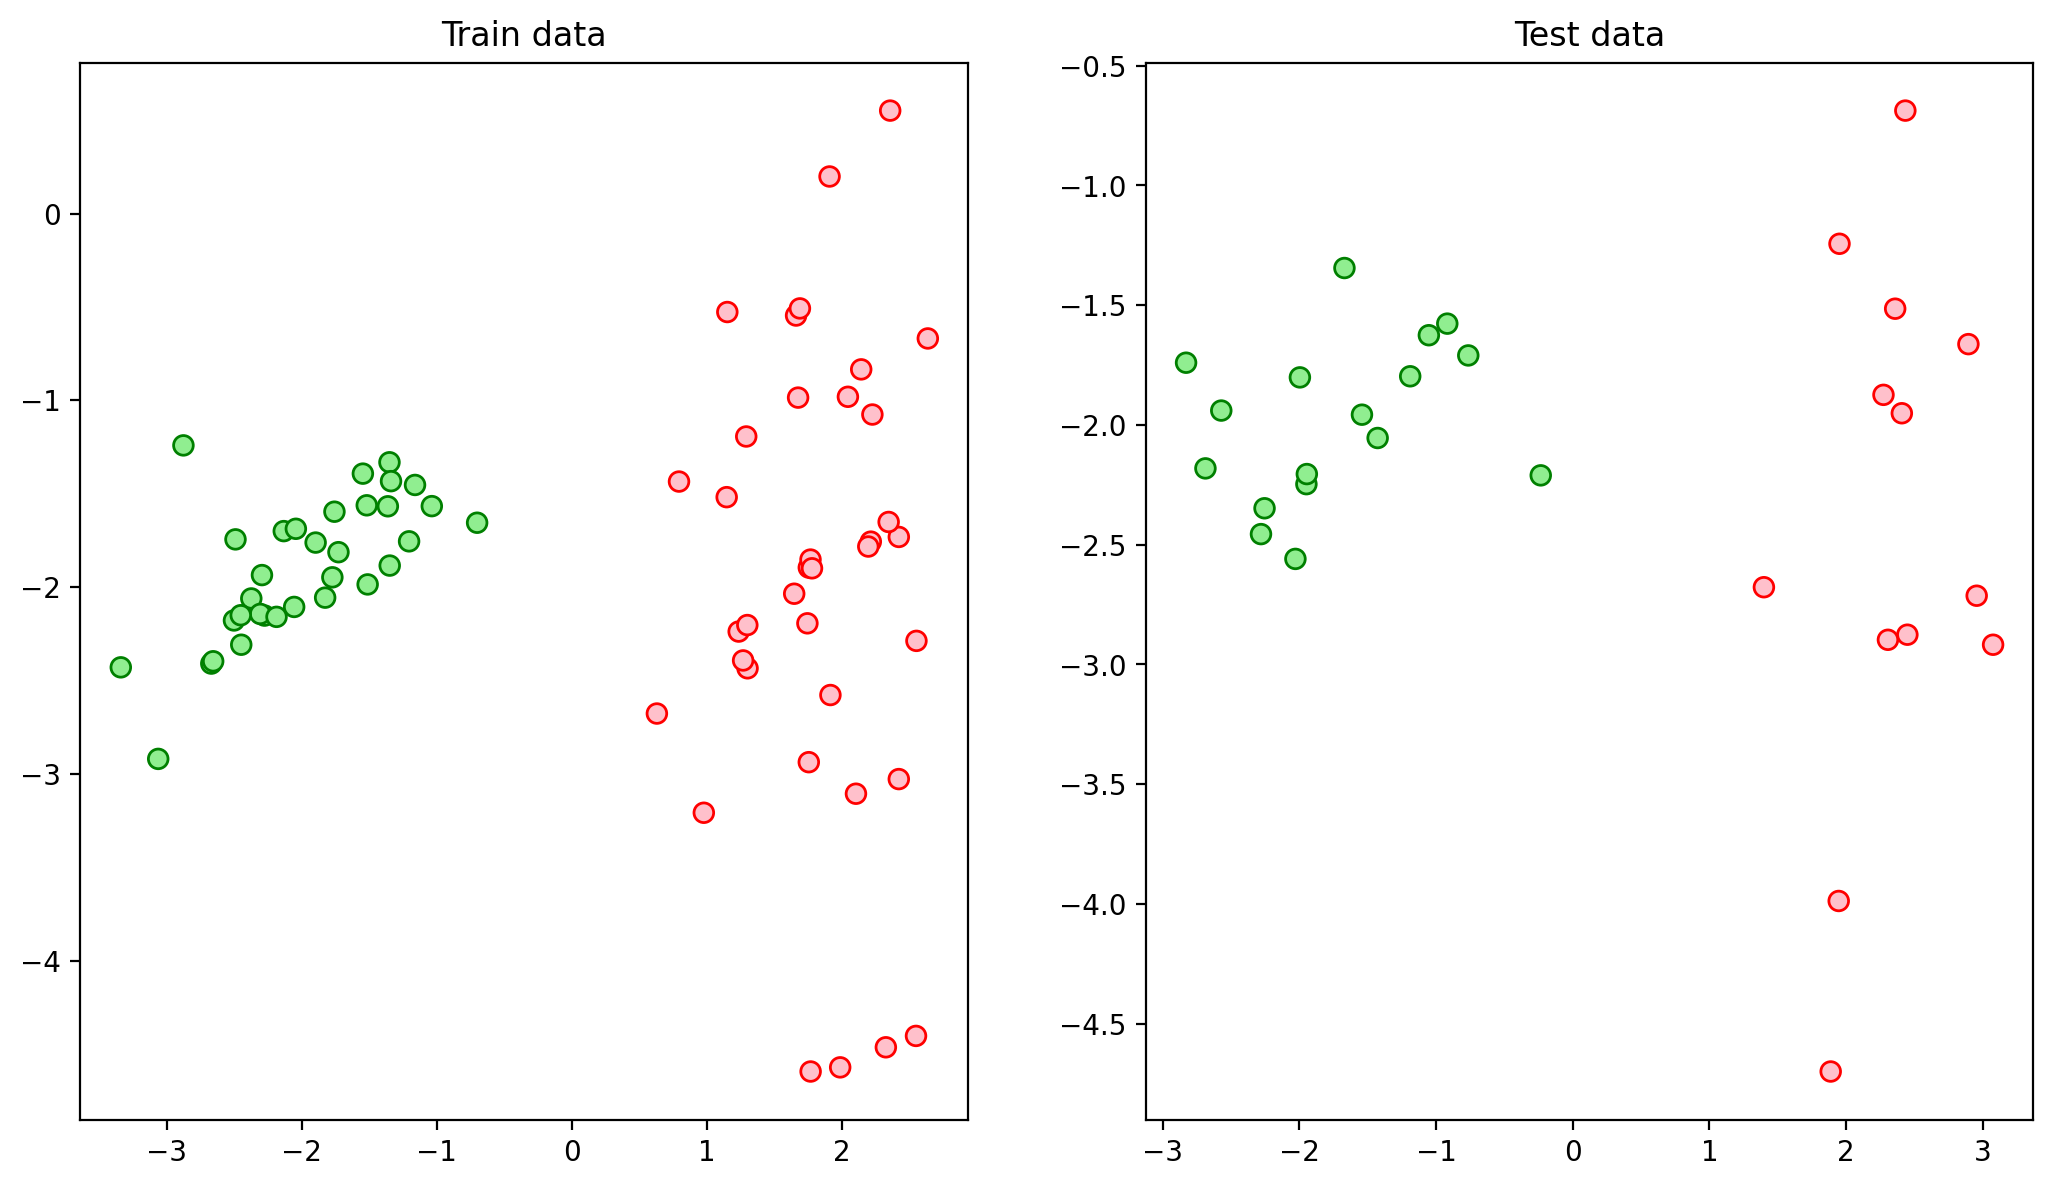

In [22]:
plt.subplot(1, 2, 1)
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train.apply(lambda y: colours[y]),
    edgecolor=y_train.apply(lambda y: edges[y]),
    s=50,
)
plt.title("Train data")
plt.subplot(1, 2, 2)
plt.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test.apply(lambda y: colours[y]),
    edgecolor=y_test.apply(lambda y: edges[y]),
    s=50,
)
plt.title("Test data")
plt.show()

We will use an SVC model as before, but now we will simply train it on the _train_ dataset.

In [23]:
svm = SVC(gamma="scale", probability=True)
svm.fit(X_train, y_train)
print(" ### Accuracy:", sum(svm.predict(X_test) == y_test) / y_test.shape[0])

 ### Accuracy: 1.0


In [24]:
def plot_classification_contour(X, clf, ax=[0, 1]):
    ## Inspired by scikit-learn documentation
    h = 0.02  # step size in the mesh
    cm = plt.cm.RdBu
    x_min, x_max = X[:, ax[0]].min() - 0.5, X[:, ax[0]].max() + 0.5
    y_min, y_max = X[:, ax[1]].min() - 0.5, X[:, ax[1]].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=cm)

Let's take the same input as previously, the point $p=(-0.5, -1)$.

Also, let's define:

* an initial `radius=0.1`
* number of "enemies", `n_enemies = 999`
* the number of points inside the layer, `n_layer=200`

In [112]:
radius = 1.0
n_enemies = 99
n_layer = 2000

Let's also add a normalising function:

In [113]:
def norm(v):
    return np.linalg.norm(v, ord=2, axis=1)

In [114]:
def generate_inside_ball(center, segment, n):
    d = center.shape[0]
    z = np.random.normal(0, 1, (n, d))
    u = np.random.uniform(segment[0] ** d, segment[1] ** d, n)
    r = u ** (1 / float(d))
    z = np.array([a * b / c for a, b, c in zip(z, r, norm(z))])
    z = z + center
    return z

In [115]:
first_layer = generate_inside_ball(center=p_input[0], segment=(0, radius), n=n_layer)

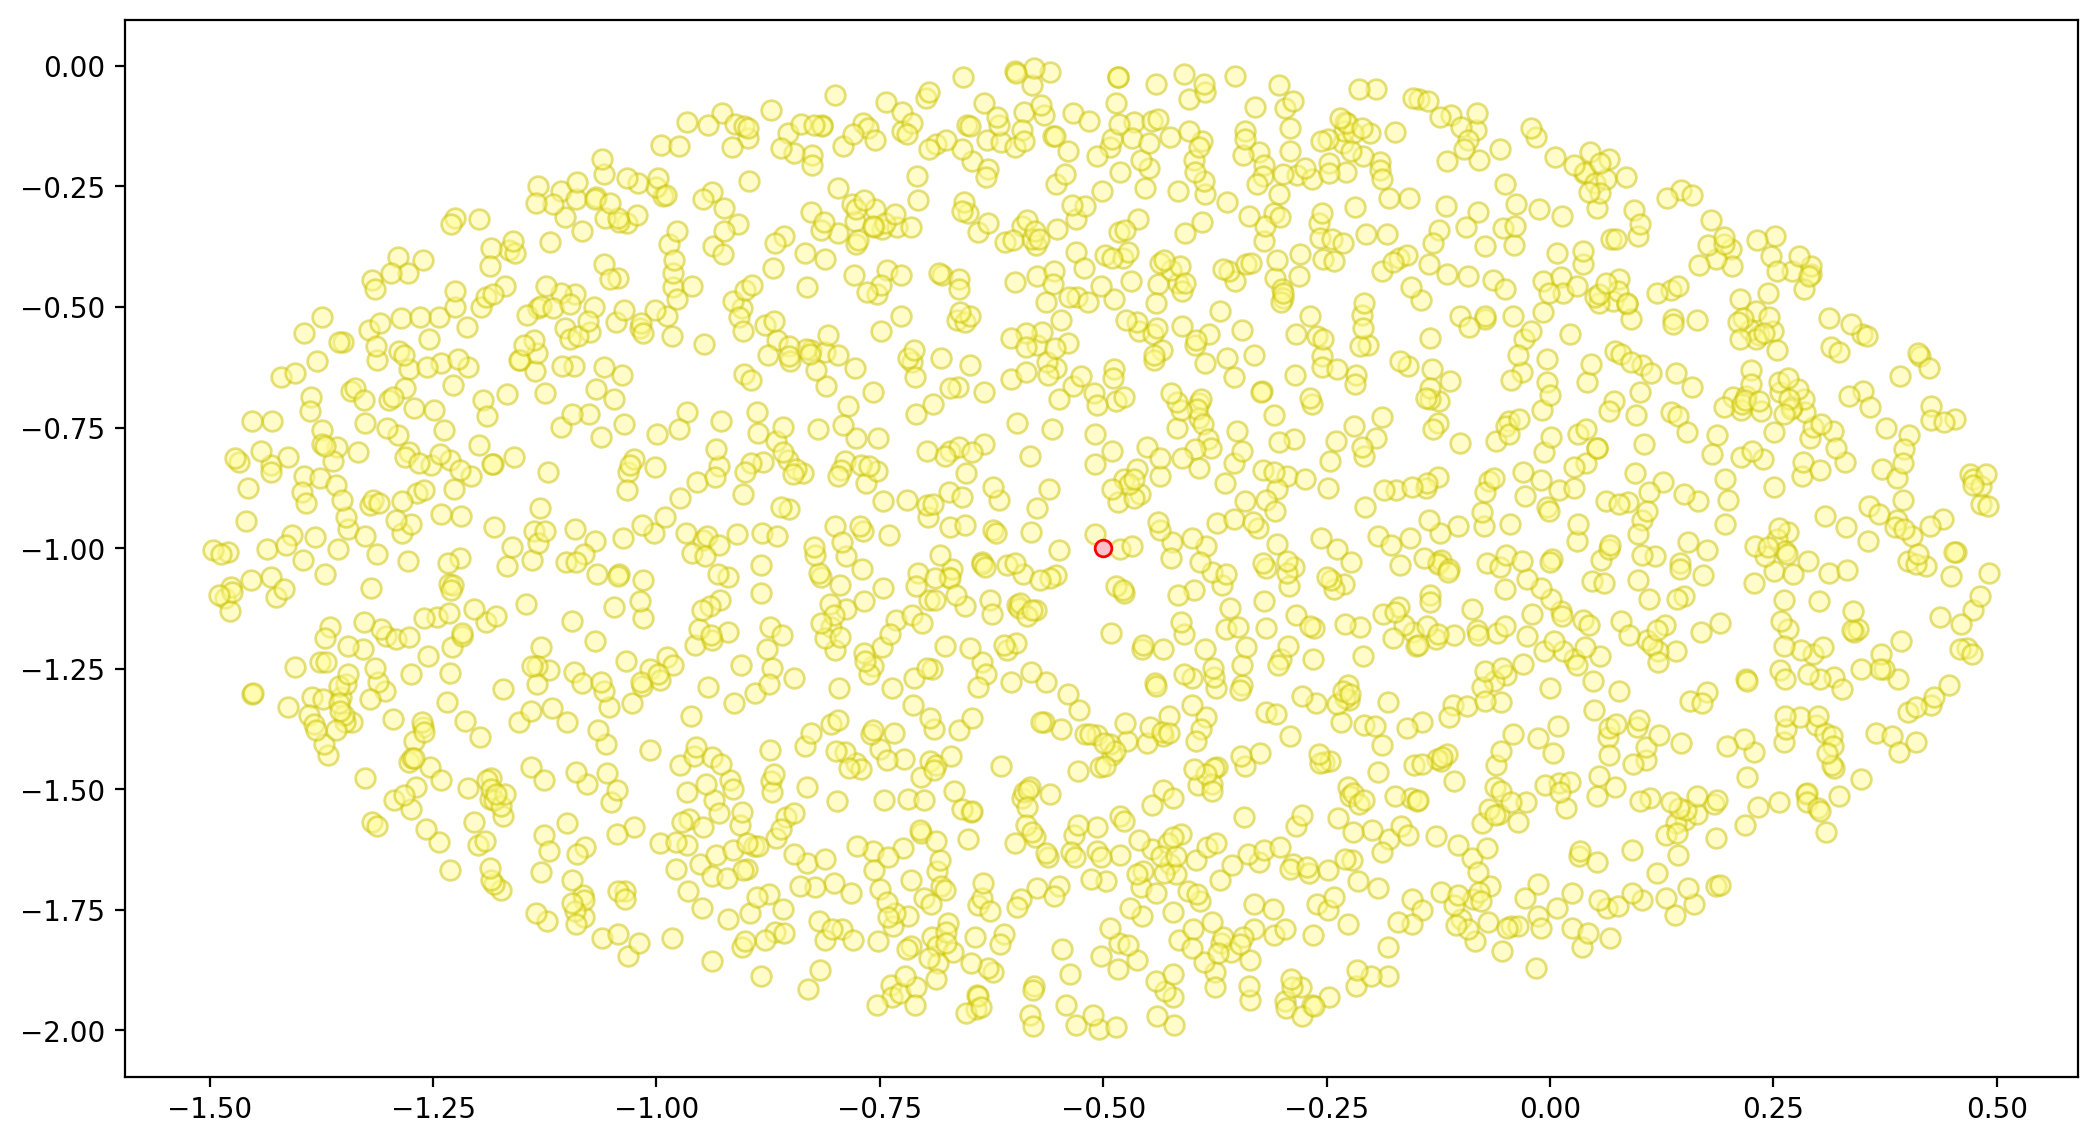

In [116]:
plt.scatter(
    first_layer[:, 0],
    first_layer[:, 1],
    c=colours[2],
    edgecolor=edges[2],
    s=50,
    alpha=0.5,
)
plt.scatter(p_input[0][0], p_input[0][1], c=colours[0], edgecolor=edges[0])
plt.show()

In [117]:
def enemies_in_layer(obs, segment, caps=None, n=1000, target_class=None, model=None):
    layer = generate_inside_ball(obs, segment, n)
    if caps != None:
        cap_fn_ = lambda x: min(max(x, caps[0]), caps[1])
        layer = np.vectorize(cap_fn_)(layer)

    preds = model.predict(layer)
    return layer[np.where(preds == 0)]

In [120]:
enemies_in_layer(p_input[0], segment=(0, radius), model=svm)[0:10, :]

array([[ 0.15989054, -0.90646986],
       [ 0.04518326, -0.57361795],
       [ 0.02823723, -1.144017  ],
       [ 0.21549694, -0.82322214],
       [ 0.13069809, -0.66377151],
       [-0.04881456, -1.06499381],
       [ 0.41367023, -1.22082701],
       [ 0.12017344, -1.27649176],
       [ 0.09725227, -0.62654572],
       [ 0.0992299 , -1.262531  ]])

In [121]:
def exploration(obs, radius, n_ennemies, caps, decrease_radius, n_in_layer, model):

    radius_ = radius
    while n_ennemies > 0:
        first_layer = enemies_in_layer(
            obs=obs, segment=(0, radius_), caps=caps, n=n_in_layer, model=model
        )
        n_ennemies = first_layer.shape[0]
        radius_ = radius_ / decrease_radius
        print("%d ennemies found in initial sphere. Zooming in..." % n_ennemies)

    else:
        print("Exploring...")
        iteration = 0
        step = (decrease_radius - 1) * radius_ / 5.0

        while n_ennemies <= 0:
            layer = enemies_in_layer(
                obs=obs,
                segment=(radius_, radius_ + step),
                caps=caps,
                n=n_in_layer,
                model=model,
            )
            n_ennemies = layer.shape[0]
            radius_ = radius_ + step
            iteration += 1
        print("Final number of iterations: ", iteration)
    print("Final radius: ", (radius_ - step, radius))
    print("Final number of ennemies: ", n_ennemies)
    return layer

In [122]:
enemies = exploration(
    obs=p_input[0],
    radius=radius,
    n_ennemies=n_enemies,
    caps=None,
    decrease_radius=2,
    n_in_layer=n_layer,
    model=svm,
)

495 ennemies found in initial sphere. Zooming in...
87 ennemies found in initial sphere. Zooming in...
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  12
Final radius:  (0.4000000000000001, 1.0)
Final number of ennemies:  6


In [123]:
from sklearn.metrics.pairwise import pairwise_distances


def counterfactual(obs, radius, n_enemies, caps, decrease_radius, n_in_layer, model):
    ennemies = exploration(
        obs=obs,
        radius=radius,
        n_ennemies=n_enemies,
        caps=caps,
        decrease_radius=decrease_radius,
        n_in_layer=n_in_layer,
        model=model,
    )
    closest_ennemy = sorted(
        ennemies, key=lambda x: pairwise_distances(obs.reshape(1, -1), x.reshape(1, -1))
    )[0]
    return closest_ennemy


closest_ennemy = counterfactual(p_input[0], radius, n_enemies, None, 2, n_layer, svm)
print(closest_ennemy)

545 ennemies found in initial sphere. Zooming in...
68 ennemies found in initial sphere. Zooming in...
0 ennemies found in initial sphere. Zooming in...
Exploring...
Final number of iterations:  12
Final radius:  (0.4000000000000001, 1.0)
Final number of ennemies:  2
[-0.0757912  -1.01178234]


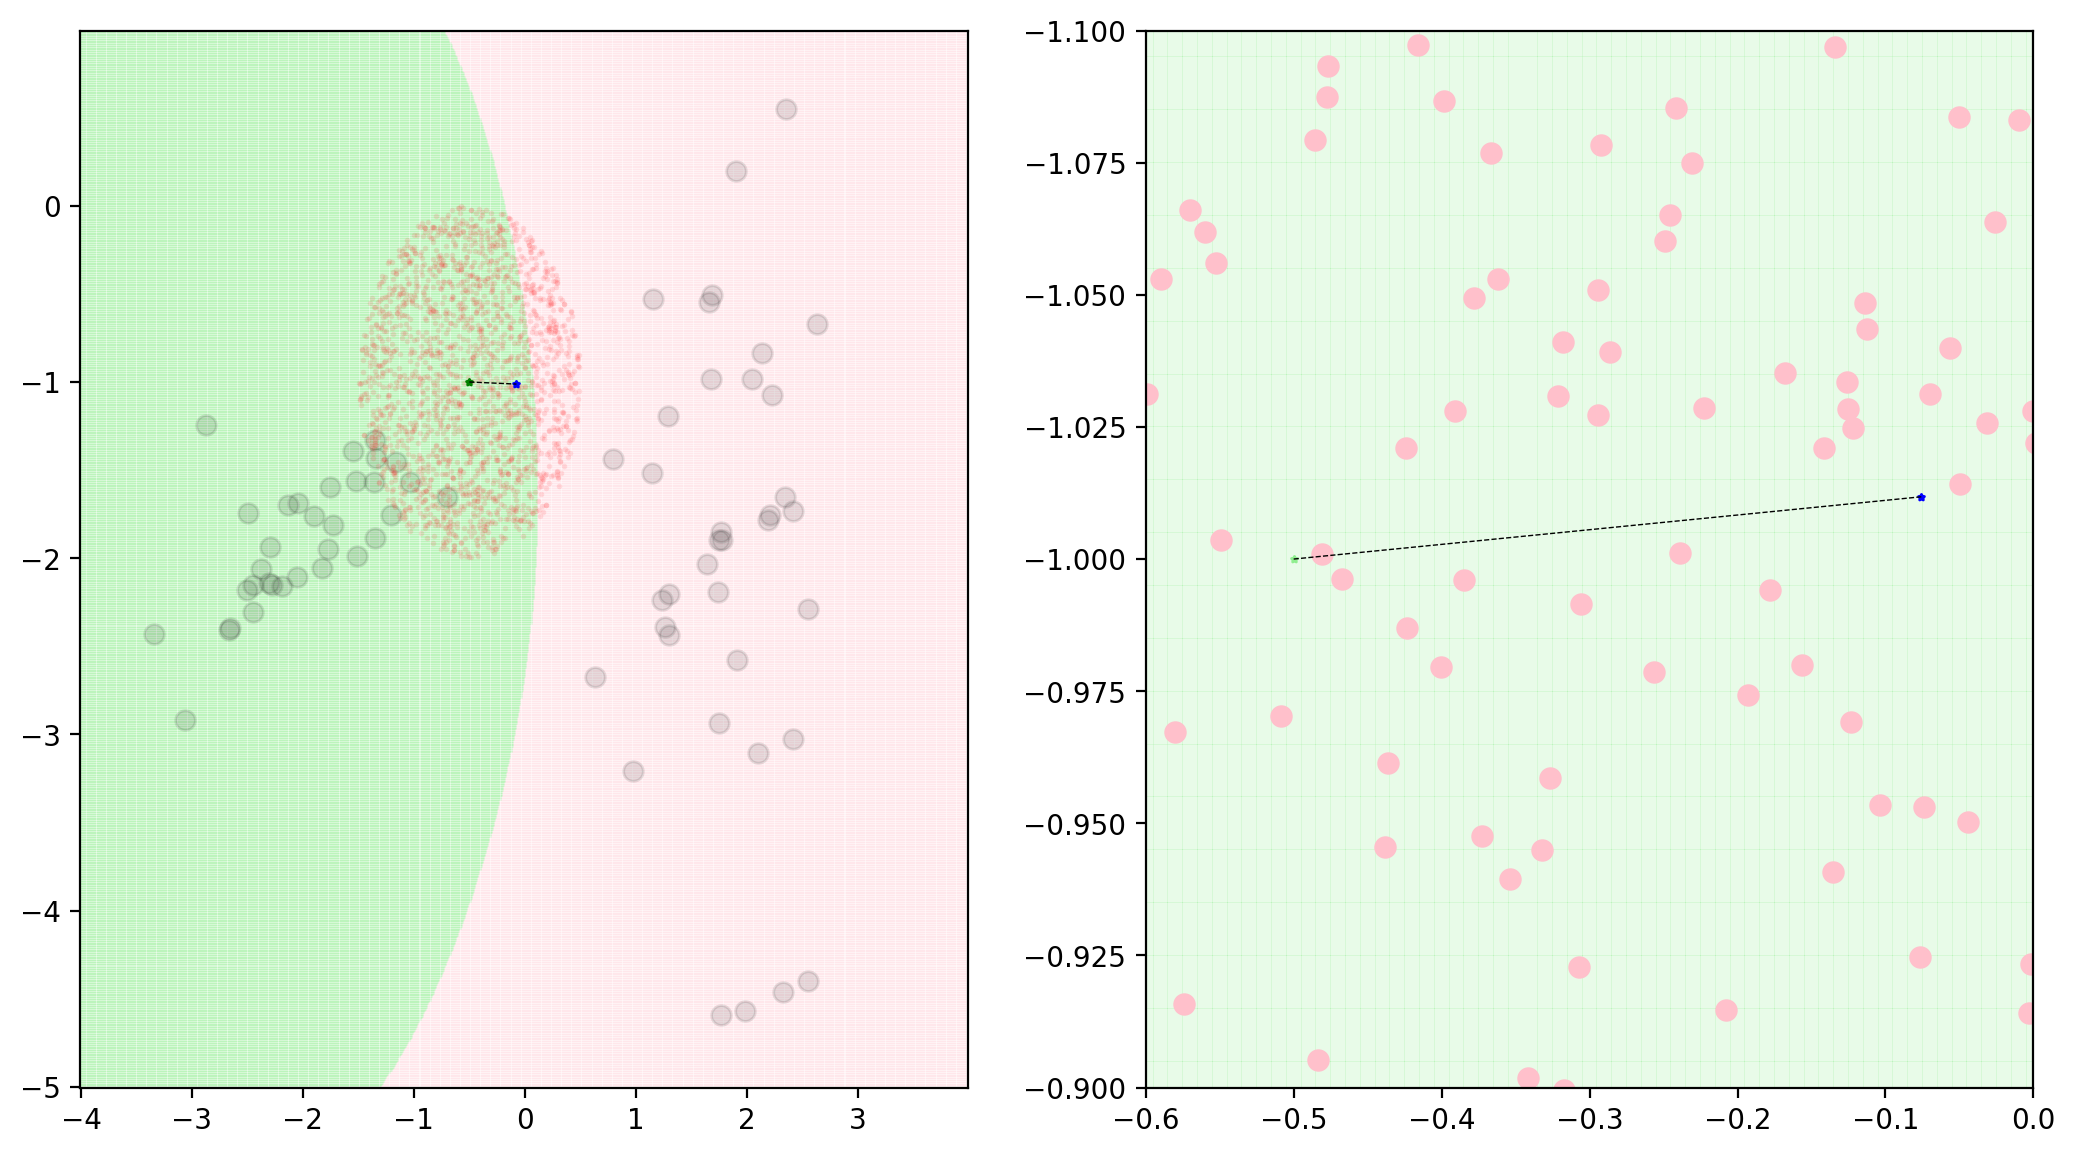

In [124]:
plt.subplot(1, 2, 1)
plt.pcolormesh(xx, yy, Z, cmap=cmap, shading="auto")
plt.scatter(X_train[:, 0], X_train[:, 1], c="k", s=50, alpha=0.1)
plt.scatter(
    first_layer[:, 0],
    first_layer[:, 1],
    c=colours[0],
    edgecolor=edges[0],
    alpha=0.1,
    s=1,
)
plt.scatter(
    p_input[0][0], p_input[0][1], c=colours[1], edgecolor=edges[1], s=5, marker=(5, 1)
)
plt.scatter(closest_ennemy[0], closest_ennemy[1], c="blue", s=5, marker=(5, 1))
plt.plot(
    [p_input[0][0], closest_ennemy[0]],
    [p_input[0][1], closest_ennemy[1]],
    "k--",
    linewidth=0.5,
)
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, Z, cmap=cmap, shading="auto")
plt.scatter(first_layer[:, 0], first_layer[:, 1], c=colours[0], s=50)
plt.scatter(p_input[0][0], p_input[0][1], c=colours[1], s=5, marker=(5, 1))
plt.scatter(closest_ennemy[0], closest_ennemy[1], c="blue", s=5, marker=(5, 1))
plt.plot(
    [p_input[0][0], closest_ennemy[0]],
    [p_input[0][1], closest_ennemy[1]],
    "k--",
    linewidth=0.5,
)
plt.xlim([-0.6, 0.0])
plt.ylim([-0.9, -1.1])
plt.show()

```{bibliography} ./references.bib
:filter: docname in docnames
```

```{bibliography} ./references.bib
```